# 1. Problem Definition

This notebook is to check the frequency of key words/phrases in various documents. These files include MS Word, Excel, and (scanned) PDFs. 

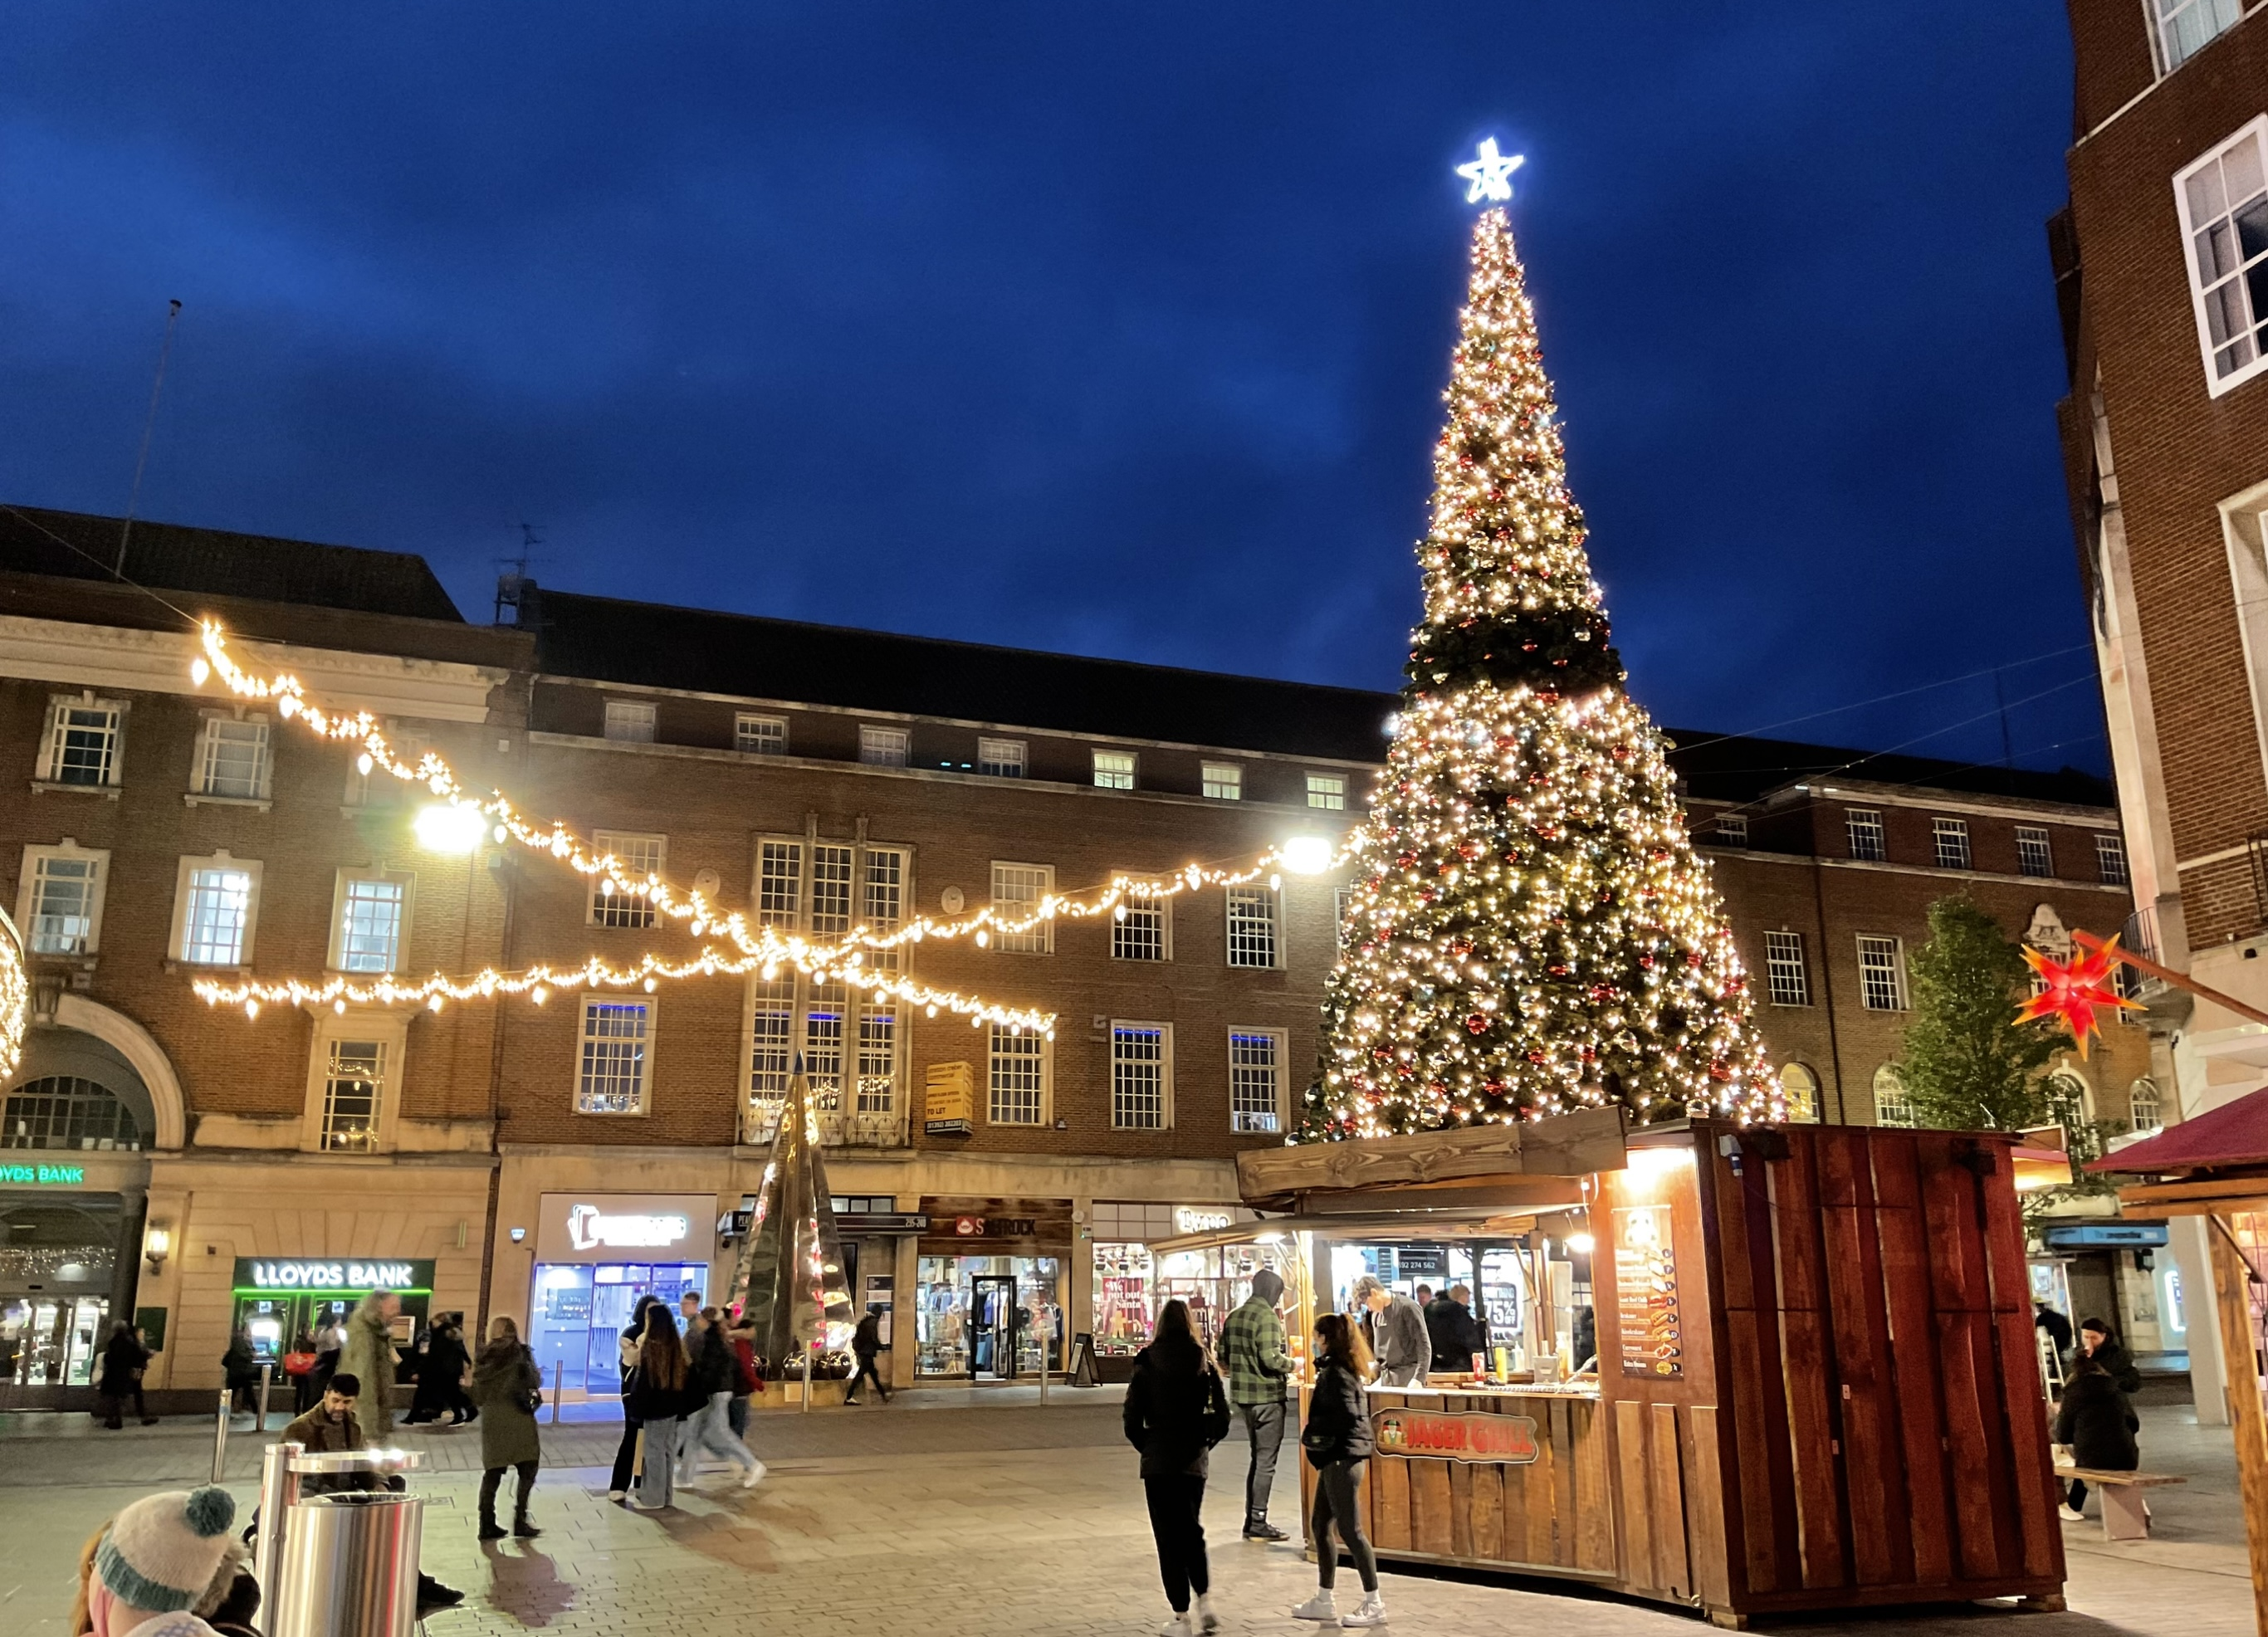

In [1]:
from IPython.display import Image
Image(filename = 'data/IMG_1257.jpg')

The work flow is below:
1. split multiple pages file into single page
2. convert into image if this page contain image
3. extract text from each page and combine text
4. remove punctuation
5. calculate frequency of key words/phrases 
6. check performance

**Class and Function**

1. Define a `class` named `Extract_TXT` to extract contents from various files. This class includes the following methods:

     `PDF_2_TXT` to extract contents from .pdf, or .PDF;

     `XLS_2_TXT` to extract contents from .xls, or .XLS;

     `XLSX_2_TXT` to extract contents from .xlsx, or .XLSX;

     `DOCX_2_TXT` to extract contents from .docx, or .DOCX;

     `DOC_2_TXT` to extract contents from .doc or .DOC

     The input of `Extract_TXT` class is file path,and methods outputs is in the contents of the file in string format. Forexample, by using this class, you can specify path `Extract_TXT(path).PDF_2_TXT()`


2. Define a `class` named `KEYS` to specify keys list, the element of this must be a list in which each words seprated by a comma. For instalce, use `KEYS.BoL_keys`to obtain the bill of lading keys list in this class


3. Define a funtion named `TEXT` to identify files extension and return extracted text in lower case of a long string. For example, `TEXT(path)` will recognise file extense and return extracted text.


4. Define a `class` named `PreProcessing_Text` to clearn extracted characters. Its method is `Remove_Punctuation`, that is all punctuations extraced from original files. This can imporve keys recognition performace. This class can also contain other methods such removing stop words, lemmtization and so on.

5. Define a function named `KEYS_LIST` to specify a list of keys string to single words in keys listy

6. Define a function `Unrecognised_keys` to check names of unrecognised keys


# 2. Import Libraries

ReadMe to install pdf2image https://github.com/Belval/pdf2image

In [2]:
# install poppler-utils for pdf2image
# !pip install poppler-utils

In [3]:
# # install poppler https://github.com/Belval/pdf2image
# !conda install -c conda-forge poppler -y
# # or install using `brew install poppler` to install on Mac OS

In [4]:
# install OCR engine tesseract on windows,Mac Os and various distributions of Linux
# https://github.com/ropensci/tesseract/blob/master/README.md

In [2]:
%%time 
# time cell runtime

import numpy as np
import pandas as pd

#Libraries for pdf conversion
# from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
# from pdfminer.converter import TextConverter
# from pdfminer.layout import LAParams
# from pdfminer.pdfpage import PDFPage
# import re
# from io import StringIO
import PyPDF2
from PyPDF2 import PdfFileReader, PdfFileWriter
import xlrd
# import docx2txt 
# import cv2
# import filetype
import pytesseract # OCR engine, requiring libtesseract-dev to be installed
from pdf2image import convert_from_path
from PIL import Image
from docx2python import docx2python
import tika
tika.initVM() # After you import Tika you need to initialize the Java Server
from tika import parser
from openpyxl import load_workbook
# import argparse
#import opencv_wrapper as cvw
from skimage.filters import threshold_local

# load NLTK
from collections import Counter
import nltk
from nltk.util import ngrams
import string
# import random
# from string import ascii_uppercase, digits, punctuation
# import colorama
# import regex
import os
import pprint
# import timeit

# Disable the warnings
import warnings
warnings.filterwarnings('ignore')

CPU times: user 1.58 s, sys: 652 ms, total: 2.23 s
Wall time: 902 ms


# 3. Create Log File
To gather information, shoot troubles, generate statistics, audit and profile, Python `logging` write information into to log files, which contains various events that occurred in operating system, software and communication.

Python logging level:
* DEBUG
* INFO
* WARNING
* ERROR
* CRITICAL
* ALERT
* EMERGENCY

DEBUG < INFO < WARNING < ERROR < CRITICAL

In [4]:
import logging
import sys
# config final order, structure, and content of the log record
LOG_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
# date format
DATE_FORMAT = "%m/%d/%Y %H:%M:%S %p"
logging.basicConfig(filename='my.log',  # save log record 
                    stream=sys.stdout,
                    level=logging.DEBUG, # set  log level
                    format=LOG_FORMAT, 
                    datefmt=DATE_FORMAT)

To specify logging level by using the following:

`logging.debug("This is a debug log.")`

`logging.info("This is a info log.")`

`logging.warning("This is a warning log.")`

`logging.error("This is a error log.")`

`logging.critical("This is a critical log.")`

# 4 Load Files

In [5]:
path18 = 'data/OBL NO. 18-SEN.pdf'
path_doc = 'data/bill-of-lading-form.doc'
path_docx = 'data/bill-of-lading-form.docx'
path_xls = 'data/bill-of-lading-template.xls'
path_xlsx = 'data/bill-of-lading-xls-data.xlsx'

In [6]:
# creating an object 
file = open(path18, 'rb')

# creating a pdf reader object
fileReader = PyPDF2.PdfFileReader(file)

# print the number of pages in pdf file
print(('There are %d pages in total') % (fileReader.numPages))

There are 2 pages in total


In [7]:
# page number start with zero
pageObj = fileReader.getPage(1)
pageObj

{'/Type': '/Page',
 '/MediaBox': [0, 0, 595.67999, 841.91998],
 '/Contents': {},
 '/Resources': {'/ProcSet': ['/PDF', '/Text', '/ImageB', '/ImageC', '/ImageI'],
  '/XObject': {'/X1': {'/Type': '/XObject',
    '/Subtype': '/Image',
    '/Height': 3508,
    '/Width': 2482,
    '/ColorSpace': '/DeviceRGB',
    '/BitsPerComponent': 8,
    '/Filter': ['/DCTDecode']}}},
 '/Parent': {'/Type': '/Pages',
  '/Kids': [IndirectObject(4, 0), IndirectObject(9, 0)],
  '/Count': 2}}

By examining the outout above, page resources includes `/XObject`, indicating that this pdf contains image

# 5 Define Class and Function

Define a `class` named `Extract_TXT` 

In [8]:
%%time

class Extract_TXT:

    def __init__(self, path):
        self.path = path
    
    #def Split_Page_Paths(path):
    def PDF_2_TXT(self):
        
        """[To extract text from multiple pdf pages
        1. split multiple pdf pages into single page
        2. check if single page contain image
        3. convert single page pdf into image and then 
        4. extract text from image, otherwise
        5. extract text from single page directly, and then
        6. combine extracted text into a lower case string]

        Args:
            path ([type]): [description]

        Returns:
            [string]: [extracted text in lower case]
        """
        # specify pdf file path   
        pdf = PdfFileReader(self.path)
        # get page number
        page_num = pdf.getNumPages()
        # print('There are %d pages in total'%(page_num))
        # initial a list to store the file paths after splitting multiplepages file
        saved_file_paths = []
        # split multiple pages into single page
        for i in range(page_num):
            pdf_writer = PdfFileWriter()
            pdf_writer.addPage(pdf.getPage(i))
            
            output = f'{self.path}{i}.pdf'
            
            saved_file_paths.append(output)
            # save single page to local
            with open(output, 'wb') as output_pdf:
                pdf_writer.write(output_pdf)
        
        # initial a string to store extracted text    
        txt = str()
  
        for index, j in enumerate(saved_file_paths):
        #for j in saved_file_paths:
            # read single pdf file from path 
            # after splitting, there is only one page per file
            # page numper start at zero            
            page_data = PdfFileReader(j).getPage(0)
            # obtain page resources
            
            page_resources = page_data["/Resources"]

            # check if this page contains impge
            #  '/XObject' indicates that this page contains image              
            if ('/XObject' in page_resources.keys()) == True:
                #print('Page %d contains image' % (index))
                
                # convert scanned pdf page into image
                im = convert_from_path(j)     
                      
                # extrace text from image using pytesseract
                # im[0] indicates the first page of the image though its a single page 
                extracted_txt = pytesseract.image_to_string(im[0], lang = 'eng')
                # make extracted text as lower case and add to txt
                txt += extracted_txt.lower()        
            else:
                #print('Page %d contains no image' % (index)) 
                # extract text from pdf directly if this page contains on image   
                extracted_txt = page_data.extractText()
                txt += extracted_txt.lower()
        
        return txt

      # This method is to extract .txt from .xls  
    def XLS_2_TXT(self):
        # open workbook with `xlrd`
        book = xlrd.open_workbook(self.path)
        # check sheet names
        sheet_names = []
        for sheet in book.sheets():
            sheet_names.append(sheet.name)
        # print(sheet_names)

        row_value = [] 
        # open work sheet
        for i in range(len(sheet_names)):
        #for i in sheet_names:            
            sheet = book.sheet_by_name(sheet_names[i])
            # retireve row values

            for j in range(sheet.nrows):
                row_value.append(sheet.row_values(j))

        return str(row_value).lower()

    # # This method is to extract .txt from .xlsx file
    # def XLSX_2_TXT(self):
    #     # open workbook with Pandas ExcelFile
    #     excel_file = pd.ExcelFile(self.path)
    #     # get sheets name
    #     sheet_names = excel_file.sheet_names
    #     print(sheet_names)
    #     text =str()
    #     for name in sheet_names:
    #         df = pd.read_excel(excel_file, name)
    #         text += str(df.values).lower()
    #     return text
    

    def XLSX_2_TXT(self):

        # Load the entire workbook.
        work_book = load_workbook(self.path)

        # List all the sheets in the file.
        sheet_name = work_book.sheetnames
        #print('Worksheet names are: ')
        #print(sheet_name)

        all_rows = []
        for i in range(len(sheet_name)):
            all_rows += list(work_book[sheet_name[i]].rows)
            #print(f"Found {len(all_rows)} rows of data.")   
            text = []
            for j in range(len(all_rows)):
                for row in all_rows[j]:
                    if row.value != None:
                        text.append(str(row.value).split())
        return str(text).lower()

    # This method is to extract .txt from .docx file
    def DOCX_2_TXT(self):
        # alternatively, to use docx2txt
        # text = docx2txt.process(self.path)

        # extract docx content using `docx2python`
        txt = docx2python(self.path)
        pprint.pprint(txt.properties)
        # extract header
        txt_header = str(txt.header)
        # extract docx body
        txt_body = str(txt.body)
        # extract docx footer
        txt_footer = str(txt.footer)
        # combine header, body and footer
        text = (txt_header + txt_body + txt_footer).lower()
        return text
    
    # This method is to extract .txt from .doc
    def DOC_2_TXT(self):
        # parse doc
        txt = parser.from_file(self.path)
        #print(parsed["metadata"]) #To get the meta data of the file
        # extract .doc content
        text = txt['content'].lower()
        return text

CPU times: user 25 µs, sys: 6 µs, total: 31 µs
Wall time: 37 µs


In [9]:
# import PyPDF2
# fhandle = open(r'/home/jason/Atlas/OTFP_1231/data/text page.pdf', 'rb')
# pdfReader = PyPDF2.PdfFileReader(fhandle)
# pagehandle = pdfReader.getPage(0)
# print(pagehandle.extractText())

Define a function names `TEXT`to extract text from various file format according to its extension

In [10]:
%%time

def TEXT(path):
    
    # recognise file extension
    file_extension = os.path.splitext(path)[1]
    #print('File extension is %s' % (file_extension))

    # extensions can be uppercase
    # make extension lowercase
    file_extension = file_extension.lower()
    
    # get extracted text by using Extract_TXT class
    txt = Extract_TXT(path)

    if file_extension == '.xls':
        return txt.XLS_2_TXT()

    elif file_extension == '.xlsx':
        return txt.XLSX_2_TXT()

    elif file_extension == '.pdf':
        return txt.PDF_2_TXT()

    elif file_extension == '.docx':
        return txt.DOCX_2_TXT()

    elif file_extension == '.doc':
        return txt.DOC_2_TXT()

    # else:
    #     pprint.pprint('Invalid file format')



CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


Define a `class` named `PreProcessing_Text` to pre-processing extracted text

In [11]:
%%time

class PreProcessing_Text:

    """
    To clean extracted text by removing
    1. punctuation “'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'”

    Returns:
        [string]: [without punctuation in lower case]
    """
    
    def __init__(self,text):
        self.text = text

    # define a method to remove punctuation
    def Remove_Punctuation(self):
        
        new_text = self.text.translate(str.maketrans('','',string.punctuation))

        return new_text

CPU times: user 16 µs, sys: 7 µs, total: 23 µs
Wall time: 26 µs


Define a funtion named `Checking_Keys` to return key words/phrases frequencies by inputting file path and key list. These keys can be a single word or a phrase

In [12]:
%%time

def Checking_Keys(path,keyslist):
    # get extracted text
    text = TEXT(path)
    # remove punctuation characters
    cleaned_words = PreProcessing_Text(text).Remove_Punctuation()
    # check max length of elements in keyslist
    len_list = []   
    for i in keyslist:
            #print(len(i))
            len_list.append(len(i))
            max_len = max(len_list)

    # initial an Count dictionary
    freq_dict = Counter()

    # iterate n-gram in 1,2,3
    # maxlen(keys)
    for n_gram in range(max_len+1):
        
        # assign words in different n_gram
        #freq_dict += Counter(ngrams(text.split(), n_gram))
        
        freq_dict += Counter(ngrams(cleaned_words.split(), n_gram))

    # initial an empty pandas dataframe
    df_key_freq = pd.DataFrame(columns=['Key Name','Frequency'])

    # iterate to get index-values of dictionary
    # index is the name of keys, value is the frequency of each word or phrase
    for index, values in freq_dict.items():

        # check if keys are in this dictionary
        for i in range(len(keyslist)):

            # if index appears in keys list
            if list(list(index)) == keyslist[i]:
                # assign index and values to dataframe
                df_key_freq = df_key_freq.append({'Key Name': index, 'Frequency': values},ignore_index = True)
                #print(list(index), values)
                
    # return key words/phrases in numpy array
    return df_key_freq.to_numpy() 


CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs


Define a function named `KEYS_LIST` to split keys words into single word and then assigne words in different list
for example, 

**input**: `sample_list = ['this is sample','this is','sample']`

**return**: `[['this', 'is', 'sample'], ['this', 'is'], ['sample']]`

and please **DO NOT** include any punctuation in input list elements since punctuation will be removed from extracted text, otherwise this may fail to parse keys words or phrases correctly

Alternatively, if you do not want to call this function, please make sure the keys list in the structure as **return** above

In [13]:
def KEYS_LIST(keys_list):
    
    '''This function returns a list of keys that seperated each words by comma,
    which is necessary before inputting into function Checking_Keys'''
    keys = []
    for i in keys_list:
        keys.append(list(str(i).split()))
    return keys

Define a list to store key words or phrases

**keys words or phrase must be in lowercase**

In [14]:
# define a class to store different keys
class KEYS:

    # this is a sample list to check key words and phrase in No.18 sample bill of lading
    # you can define your own keywords and phrase
    BoL_keys = ['code name',
                'shipper',
                'consignee',
                'notify party',
                'bill of lading',
                'owners name',
                'vessel',
                'port of loading',
                'port of discharge',
                'description of goods',
                'gross weight',
                'clean on board date',
                'charter party dated',
                'freight payable at',
                'printed and sold by',
                'conditions of carriage',
                'general paramount clause',
                'general average',
                'new jason clause',
                'both to blame collision clause',
                'as agents only', # blue stamp
                'thanh tin service and trade company limited' # red stamp

                ]
    # this is some keywords in Wells Fargo's annual report
    keys_10K = ['statement of income',
                        'statement of comprehensive income',
                        'financial review',
                        'earning assets',
                        'noninterest earning assets', # noninterest-earning assets
                        'taxable equivalent basis', # taxable-equivalent basis, 6 times
                        'total assets',
                        'total interest bearing deposits' # Total interest-bearing deposits
                        'noninterest income',
                        'three months ended september 30 2016', # page 48 on chart
                        'third quarter 2016', # page 52
                        'guarantees pledged assets and collateral',
                        'balance sheet',
                        'statement of changes in equity',
                        'statement of cash flows',
                        'net income',
                        'dividends',
                        'goodwill',
                        'common shares outstanding',
                        'revenue',
                        'roe', # return on equity
                        'roa', #return on assets
                        'xbrl taxonomy extension presentation linkbase document'# p163
                        ]
    
    
    # this is some keywords 'bill-of-lading-template.xls''
    keys_MS_xls= ['bill of lading',
                        'consignee',
                        'carrier name',
                        'carrier address',
                        'freight bill pro no', 
                        'special instructions', 
                        'trailercar number', # TRAILER/CAR NUMBER
                        'shipment identification no',
                        'for payment send bill to',
                        'shippers internal data', # SHIPPER'S INTERNAL DATA
                        'number shipping units', 
                        'remit cod', 
                        'cod fee',
                        'check box if collect',
 
                        ]
    
    # this is some keywords 'data/bill-of-lading-xls-data.xlsx'
    keys_MS_xlsx= ['db schenker',
                  'carrier name',
                  'carrier address',
                  'freight bill pro no',
                  'trailercar number', # TRAILER/CAR NUMBER
                  'consignee',
                   'special instructions',
                   'shippers internal data',
                   'for payment send bill to',
                   'number shipping units',
                   'kinds of packaging description of articles special marks and exceptions',
                   'check box if collect',
                   'signature of consignor',
                   'shipper',
                   'carrier',
                   'remit cod to',
                   'this is second worksheet'
                    ]
    
    # this is some keywords `bill-of-lading-form.doc`
    keys_MS_word= ['bill of lading',
                        'consignee',
                        'shipper',
                        'shippers instructions', 
                        'no shipping units', 
                        'time',
                        'weight', 
                        'rate',
                        'remit cod', # REMIT .C.O.D
                        'address', 
                        'cod amount',
                        'cod fee prepaid collect',
                        'subject to the classifications and tariffs ',
                        'unless market prepaid'
                        ]

# 6. Checking Keys

To obtain the key words/phrases refrequency, call the funtion `Checking_Keys`:

**input** is file path and key list
**return** a two diamension array with keys name and its frequency;
unrecognised keys is not listed

In [15]:
%%time
# check sample bill of lading keys
keys = KEYS_LIST(KEYS.BoL_keys)
keys_array_BoL = Checking_Keys(path18, keys)
# log info level
logging.info(keys_array_BoL)


CPU times: user 90.2 ms, sys: 86.7 ms, total: 177 ms
Wall time: 6.22 s


read log record

In [16]:
cat my.log

01/06/2022 10:04:16 AM - INFO - [[('shipper',) 1]
 [('consignee',) 1]
 [('vessel',) 15]
 [('code', 'name') 2]
 [('notify', 'party') 1]
 [('owners', 'name') 1]
 [('gross', 'weight') 2]
 [('general', 'average') 5]
 [('port', 'of', 'loading') 2]
 [('port', 'of', 'discharge') 2]
 [('description', 'of', 'goods') 1]
 [('bill', 'of', 'lading') 4]
 [('charter', 'party', 'dated') 2]
 [('freight', 'payable', 'at') 1]
 [('conditions', 'of', 'carriage') 2]
 [('as', 'agents', 'only') 1]
 [('general', 'paramount', 'clause') 1]
 [('new', 'jason', 'clause') 1]
 [('clean', 'on', 'board', 'date') 1]
 [('printed', 'and', 'sold', 'by') 1]
 [('thanh', 'tin', 'service', 'and', 'trade', 'company', 'limited') 2]]


By looking at the output above, key words and phrase are recognised correctly. 
For example,these two phrase `'as agents only'`on blue stamp `'thanh tin service and trade company limited'` on red stamp are identified successfully. This suggestes that this microservece is able to extract key words and phrase from a multi-pages file containing image. The key performance is affected by the the OCR engine while extracing text from image and the resolution of the image.

In [19]:
# load
path10k = 'data/10K.pdf'

In [20]:
%%time
#check Wells Fargos annual report, which contains cash flow statement and income statement
keys = KEYS_LIST(KEYS.keys_10K)
keys_array_10K = Checking_Keys(path10k, keys)
logging.info(keys_array_10K)

CPU times: user 3.84 s, sys: 279 ms, total: 4.12 s
Wall time: 18.6 s


In [21]:
%%time
# check sample bill of lading keys
keys = KEYS_LIST(KEYS.keys_MS_word)
keys_array_MS_doc = Checking_Keys(path_doc, keys)
logging.info(keys_array_MS_doc)

CPU times: user 26.7 ms, sys: 5.07 ms, total: 31.8 ms
Wall time: 206 ms


In [22]:
%%time
# check sample bill of lading keys
keys = KEYS_LIST(KEYS.keys_MS_word)
keys_array_MS_docx = Checking_Keys(path_docx, keys)
logging.info(keys_array_MS_docx)

{'created': '2021-12-14T22:45:00Z',
 'creator': 'Entrepreneur',
 'description': None,
 'keywords': None,
 'lastModifiedBy': 'Lu, Zhenxian',
 'modified': '2021-12-15T00:16:00Z',
 'revision': '4',
 'subject': None,
 'title': 'BILL OF LADING'}
CPU times: user 46.8 ms, sys: 4.69 ms, total: 51.5 ms
Wall time: 51 ms


In [23]:
path_xls

'data/bill-of-lading-template.xls'

In [24]:
# KEYS.keys_MS_xls

In [25]:
#pprint.pprint(TEXT(path_xls))

In [26]:
KEYS.keys_MS_xls

['bill of lading',
 'consignee',
 'carrier name',
 'carrier address',
 'freight bill pro no',
 'special instructions',
 'trailercar number',
 'shipment identification no',
 'for payment send bill to',
 'shippers internal data',
 'number shipping units',
 'remit cod',
 'cod fee',
 'check box if collect']

In [27]:
%%time
# check sample bill of lading keys
keys = KEYS_LIST(KEYS.keys_MS_xls)
keys_array_xls = Checking_Keys(path_xls, keys)
logging.info(keys_array_xls)

CPU times: user 22.3 ms, sys: 1.59 ms, total: 23.9 ms
Wall time: 41.5 ms


In [28]:
%%time
# check sample bill of lading keys
keys = KEYS_LIST(KEYS.keys_MS_xlsx)
keys_array_xlsx = Checking_Keys(path_xlsx, keys)
logging.info(keys_array_xlsx)

CPU times: user 140 ms, sys: 2.77 ms, total: 142 ms
Wall time: 142 ms


# 7 Check Performace 

in terms of the wether or not it recognizes the keys. Checking frequency is not in this statge.

Define a function named `Unrecognised_Keys` to check which keys are not recognized

In [29]:
def Unrecognised_Keys(keys_array,keys_list):
    
    df_freq_array = pd.DataFrame(keys_array, columns = ['keys name','frequency'])
    
    print('This is final output of keys and frequency in dataframe')
    
    print(df_freq_array)
    
    temp_list, Unrecognised_Keys = [], []
    for i in list(df_freq_array['keys name'].values):
        temp_list.append(list(i))
    print('There are %d keys in target list in total'%(len(KEYS_LIST(keys_list))))
    for index, name in enumerate(KEYS_LIST(keys_list)):
        
        if name not in temp_list:
            Unrecognised_Keys.append(name)
            print(('No. %d key is not recognised')%(index))
                      
    return Unrecognised_Keys

Check BoL keys words performance

In [30]:
%%time

Unrecognised_Keys(keys_array_BoL,KEYS.BoL_keys)

This is final output of keys and frequency in dataframe
                                            keys name frequency
0                                          (shipper,)         1
1                                        (consignee,)         1
2                                           (vessel,)        15
3                                        (code, name)         2
4                                     (notify, party)         1
5                                      (owners, name)         1
6                                     (gross, weight)         2
7                                  (general, average)         5
8                                 (port, of, loading)         2
9                               (port, of, discharge)         2
10                           (description, of, goods)         1
11                                 (bill, of, lading)         4
12                            (charter, party, dated)         2
13                             (freight, payable

[['both', 'to', 'blame', 'collision', 'clause']]

Check keys 10K annual report key words performace

In [31]:
%%time

Unrecognised_Keys(keys_array_10K,KEYS.keys_10K)

This is final output of keys and frequency in dataframe
                                            keys name frequency
0                                              (roa,)         2
1                                          (revenue,)        49
2                                        (dividends,)        26
3                                         (goodwill,)        34
4                                              (roe,)         3
5                                    (balance, sheet)        88
6                                 (financial, review)         4
7                                       (net, income)        58
8                                   (earning, assets)        11
9                                     (total, assets)        24
10                            (statement, of, income)         5
11                      (common, shares, outstanding)        13
12                             (third, quarter, 2016)        77
13                       (taxable, equivalent, b

[['noninterest', 'earning', 'assets'],
 ['total', 'interest', 'bearing', 'depositsnoninterest', 'income']]

Check MS doc bill of lading performamce

In [32]:
%%time

Unrecognised_Keys(keys_array_MS_doc,KEYS.keys_MS_word)

This is final output of keys and frequency in dataframe
                                            keys name frequency
0                                        (consignee,)         2
1                                          (shipper,)         5
2                                             (time,)         2
3                                           (weight,)         1
4                                             (rate,)         2
5                                          (address,)         1
6                            (shippers, instructions)         1
7                                        (remit, cod)         1
8                                       (cod, amount)         1
9                                  (bill, of, lading)         6
10                              (no, shipping, units)         1
11                          (unless, market, prepaid)         1
12                       (cod, fee, prepaid, collect)         1
13  (subject, to, the, classifications, and, tar

[]

Check .docx file performance

In [33]:
%%time

Unrecognised_Keys(keys_array_MS_docx, KEYS.keys_MS_word)

This is final output of keys and frequency in dataframe
                                            keys name frequency
0                                        (consignee,)         2
1                                          (shipper,)         5
2                                             (time,)         2
3                                           (weight,)         1
4                                             (rate,)         2
5                                          (address,)         1
6                            (shippers, instructions)         1
7                                        (remit, cod)         1
8                                       (cod, amount)         1
9                               (no, shipping, units)         1
10                          (unless, market, prepaid)         1
11                                 (bill, of, lading)         4
12  (subject, to, the, classifications, and, tariffs)         1
There are 14 keys in target list in total
No. 11

[['cod', 'fee', 'prepaid', 'collect']]

Check .xlsx file performance

In [34]:
%%time

Unrecognised_Keys(keys_array_xlsx, KEYS.keys_MS_xlsx)

This is final output of keys and frequency in dataframe
                                            keys name frequency
0                                          (carrier,)         7
1                                        (consignee,)         2
2                                          (shipper,)         5
3                                     (carrier, name)         1
4                                (trailercar, number)         1
5                             (special, instructions)         1
6                          (shippers, internal, data)         1
7                           (number, shipping, units)         1
8                                    (remit, cod, to)         1
9                          (signature, of, consignor)         1
10                           (freight, bill, pro, no)         1
11                          (check, box, if, collect)         1
12                      (this, is, second, worksheet)         1
13                     (for, payment, send, bill

[['db', 'schenker'], ['carrier', 'address']]

Check .xls file performance

In [35]:
%%time

Unrecognised_Keys(keys_array_xls, KEYS.keys_MS_xls)

This is final output of keys and frequency in dataframe
                         keys name frequency
0                     (consignee,)         2
1                  (carrier, name)         1
2               (carrier, address)         1
3             (trailercar, number)         1
4          (special, instructions)         1
5                     (remit, cod)         1
6                       (cod, fee)         1
7               (bill, of, lading)        10
8       (shippers, internal, data)         1
9        (number, shipping, units)         1
10        (freight, bill, pro, no)         1
11       (check, box, if, collect)         1
12  (for, payment, send, bill, to)         1
There are 14 keys in target list in total
No. 7 key is not recognised
CPU times: user 1.55 ms, sys: 71 µs, total: 1.62 ms
Wall time: 1.56 ms


[['shipment', 'identification', 'no']]